In [48]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             ConfusionMatrixDisplay, roc_curve, auc)

In [49]:
# Load dataset
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\final.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X = data.drop('target', axis=1)
y = data['target']

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y
)
print(f"\nTrain-val size: {len(X_trainval)}, Test size: {len(X_test)}")
print("Test set class distribution:", np.unique(y_test, return_counts=True))


Train-val size: 13105, Test size: 3277
Test set class distribution: (array([0, 1]), array([1638, 1639]))


In [56]:
# XGBoost model setup
model = xgb.XGBClassifier(random_state=42, n_jobs=-1)

# Hyperparameter grid
'''param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4]
}'''

param_dist = {
    'learning_rate': [0.3],
    'max_depth': [4],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'n_estimators': [200],
    'gamma': [0.3],
    'min_child_weight': [4]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1,
    scoring='accuracy',
    cv=5,
    verbose=1,  # Reduced verbosity
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits



=== Final Test Set Performance ===
ROC AUC: 0.9967
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1638
           1       0.97      0.97      0.97      1639

    accuracy                           0.97      3277
   macro avg       0.97      0.97      0.97      3277
weighted avg       0.97      0.97      0.97      3277



<Figure size 800x600 with 0 Axes>

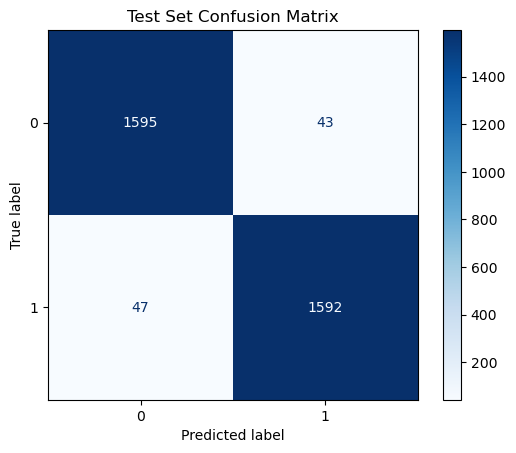

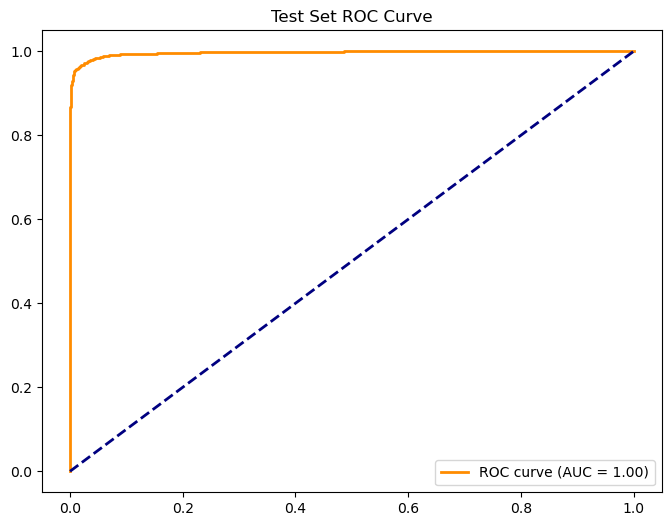

In [52]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\n=== Final Test Set Performance ===")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Test Set ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba
y_proba = evaluate_model(best_model, X_test, y_test)

In [53]:
print("\nBest Hyperparameters:")
print(random_search.best_params_)


Best Hyperparameters:
{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 1.0}



=== SHAP Analysis ===


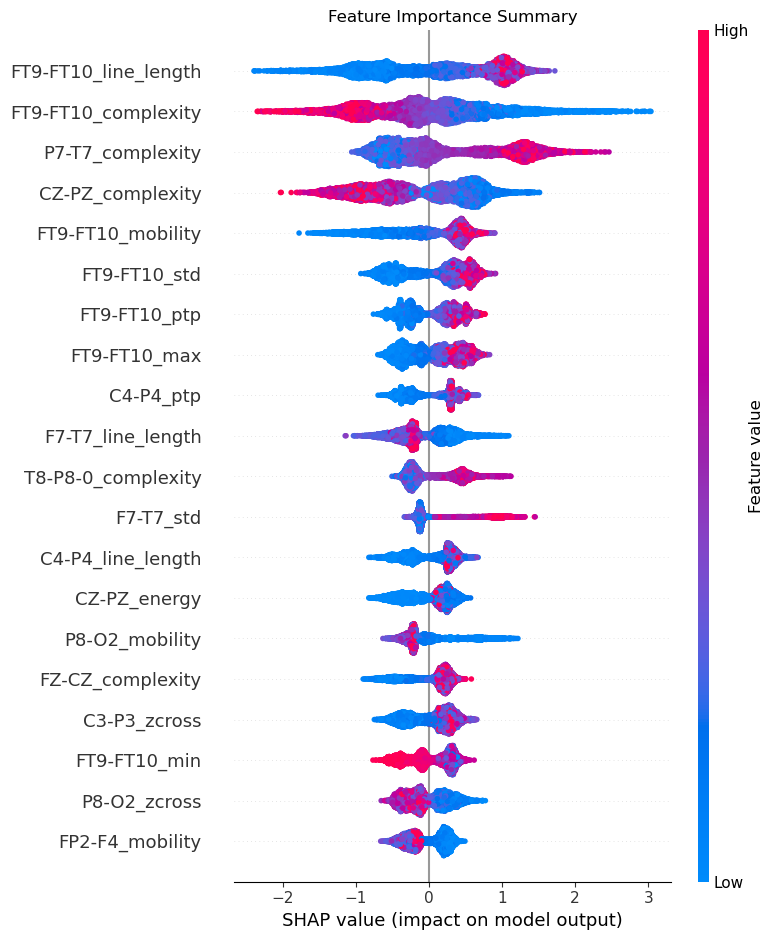

In [54]:
def shap_analysis(model, X, sample_size=10000):
    print("\n=== SHAP Analysis ===")
    
    # Sample data for faster computation
    X_sample = X.iloc[:sample_size]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_sample)  # Corrected method
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title("Feature Importance Summary")
    plt.tight_layout()
    plt.show()
    

shap_analysis(best_model, X_train)

In [55]:
from sklearn.metrics import classification_report
import json
y_pred = best_model.predict(X_test)
# Example: Assuming you have y_true (true labels) and y_pred (predicted labels)
report = classification_report(y_test, y_pred, output_dict=True)

# Save as a JSON file
with open("D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\Plots\\XGBOOST.json", "w") as f:
    json.dump(report, f, indent=4)
